In [111]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/att-database-of-faces/README
/kaggle/input/att-database-of-faces/s32/3.pgm
/kaggle/input/att-database-of-faces/s32/1.pgm
/kaggle/input/att-database-of-faces/s32/9.pgm
/kaggle/input/att-database-of-faces/s32/8.pgm
/kaggle/input/att-database-of-faces/s32/6.pgm
/kaggle/input/att-database-of-faces/s32/7.pgm
/kaggle/input/att-database-of-faces/s32/2.pgm
/kaggle/input/att-database-of-faces/s32/10.pgm
/kaggle/input/att-database-of-faces/s32/4.pgm
/kaggle/input/att-database-of-faces/s32/5.pgm
/kaggle/input/att-database-of-faces/s39/3.pgm
/kaggle/input/att-database-of-faces/s39/1.pgm
/kaggle/input/att-database-of-faces/s39/9.pgm
/kaggle/input/att-database-of-faces/s39/8.pgm
/kaggle/input/att-database-of-faces/s39/6.pgm
/kaggle/input/att-database-of-faces/s39/7.pgm
/kaggle/input/att-database-of-faces/s39/2.pgm
/kaggle/input/att-database-of-faces/s39/10.pgm
/kaggle/input/att-database-of-faces/s39/4.pgm
/kaggle/input/att-database-of-faces/s39/5.pgm
/kaggle/input/att-database-of-faces

# **1. Import the Libraries**

In [112]:
# Import libraries
import matplotlib.pyplot as plt
from PIL import Image
import imageio.v3 as iio
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import os
import cv2

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# **2. Load the Dataset and Visualize**

In [113]:
root_dir = "/kaggle/input/att-database-of-faces"
img_path = []
for person_id in os.listdir(root_dir):
    person_id_dir = os.path.join(root_dir, person_id)
    if os.path.isdir(person_id_dir):  # Ensure it's a directory
        for person_img_id in os.listdir(person_id_dir):
            person_img_path = os.path.join(person_id_dir, person_img_id)
            img_path.append(person_img_path)

In [114]:
class VCASDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the classes (subdirectories).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []  # List to store image paths and corresponding labels
        
        # Load all image paths and their respective labels
        for class_idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.samples.append((img_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('L')  # Ensure images are Grayscale
        if self.transform:
            image = self.transform(image)
        return {'image': image, 'label': label}

# **3. Visual Acuity and Contrast Sensitivity Implementation**

In [115]:
class Utility:
    def __init__(self, age, image_path):
        self.age = age
        self.image_path = image_path

    
    def get_sigma(self):
        '''
        Parameters:
        None
        Output:
        returns the estimate value of sigma corresponding to the blur in visual acuity.
        '''
        # Validate that age is non-negative
        if self.age < 0:
            raise ValueError("Age cannot be negative. Please provide a valid age in months.")
        
        if self.age <= 1:
            # Snellen - 20/600 (newborn to 1 month)
            snellen, sigma = "20/600", 4
        elif 1 < self.age <= 4:
            # Snellen - 20/480 (1 to 4 months)
            snellen, sigma = "20/489", 3
        elif 4 < self.age <= 8:
            # Snellen - 20/373 (4 to 8 months)
            snellen, sigma = "20/373", 2
        elif 8 < self.age <= 24:
            # Snellen - 20/221 (8 to 24 months)
            snellen, sigma = "20/221", 1
        else:
            # Snellen - 20/20 (24+ months)
            snellen, sigma = "20/20", 0
        
        return snellen, sigma

    
    def get_kernel_size(self, sigma):
        '''
        Output:
        Returns the nearest odd kernel size corresponding to the value of sigma.
        '''
        kernel_size = max(1, int(6 * sigma))  # Ensure a minimum kernel size of 1
        if kernel_size % 2 == 0:  # Ensure the kernel size is odd
            kernel_size += 1
        return kernel_size

    def get_cpd(self):
        """
        Parameters:
        age: (in months).
        Output:
        cutoff_frequency: The frequency threshold for the given age.
    
        Map age to cutoff frequency for CSF (low-pass filter). 
        Contrast sensitivity increases with age.
        """
        if self.age <0:
            raise ValueError("Age cannot be negative.")
    
        if 0< self.age <=1:
            cpd = 2.4
        elif 1< self.age <=2:
            cpd = 2.8
        elif 2< self.age <=3:
            cpd = 4
        elif 3< self.age <=6:
            cpd = 8
        elif 6< self.age <=12:
            cpd = 10
        elif 12< self.age <=72:
            cpd = 20
        elif 72< self.age <=240:
            cpd = 32
        else:
            cpd = 32
            
        return cpd

    
    def load_image(self):
        """
        Load the image.
        """
        # If it's a file path, open the image
        if isinstance(self.image_path, str):  
            original_image = Image.open(self.image_path).convert('L') 
        elif isinstance(self.image_path, torch.Tensor):  
            # If it's already a tensor and convert tensor to a PIL Image
            original_image = transforms.ToPILImage()(self.image_path.squeeze(0))
        else:
            # In this case this is a image matrix
            return self.image_path
        
        return original_image


    
    def display_output(self, original_image, blurred_image, snellen, effect):
        '''
        Parameters:
        original_image (PIL Image): The original loaded image in grayscale.
        blurred_image (torch.Tensor): The image after applying Gaussian blur.

        Output:
        Displays the original and blurred images in subplots.
        '''
        # Convert image back to PIL format for display
        original_pil = original_image
        if effect == "Contrast sensitivity":
            blurred_pil = blurred_image
        else:
            blurred_pil = transforms.ToPILImage()(blurred_image.squeeze(0))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))
        
        # Set the main title for the entire figure (suptitle)
        plt.suptitle(effect, fontsize=10)
        
        # Original image
        ax1.imshow(original_pil, cmap='gray')
        ax1.set_title("Original Image.", fontsize=8)
        ax1.axis('off')
        
        # Output image
        ax2.imshow(blurred_pil, cmap='gray')
        ax2.set_title(f"Output image with {snellen} vision.", fontsize=8) 
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        


class VisualAcuity(object):
    def __init__(self, age):
        self.age = age

    def __call__(self, image_path):
        '''
        Parameters:
        None
        Output:
        maps age to the snellen chart value and then maps this 
        snellen chart value to gaussian kernel and apply the 
        similar blur on the images and produces the output.
        '''
        age_params = Utility(age=self.age, image_path=image_path)
        
        # Load the original image
        original_image = age_params.load_image()
        
        # Convert the image to a PyTorch tensor and add batch and channel dimensions
        original_tensor = transforms.ToTensor()(original_image).unsqueeze(0)

        # Apply Gaussian blur
        snellen_value, sigma = age_params.get_sigma()
        kernel_size = age_params.get_kernel_size(sigma)

        # Apply Gaussian blur to the image tensor
        if sigma > 0:
            blurred_image = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)(original_tensor)
        else:
            # If sigma is 0, the blurred image is the same as the original
            blurred_image = original_tensor
        
        # Display the output
        # age_params.display_output(original_image, blurred_image, snellen_value, "Visual Acuity")

        return blurred_image
        
        
        
class ContrastSensitivity(object):
    def __init__(self, age):
        self.age = age

    
    def __call__(self, image_path):
        """
        Parameters:
        image: Grayscale image as a numpy array.
        age: (age in months) to set CSF cutoff frequency.
        Output:
        filtered image after applying the CSF-based low-pass filter.
        """
        age_params = Utility(age=self.age, image_path=image_path)
        
        # Load the original image
        original_image = age_params.load_image()
        
        image = np.array(original_image)
        
        snellen_value, sigma = age_params.get_sigma()
        
        # Get cutoff frequency based on age group
        cutoff_frequency = age_params.get_cpd()
        
        # Fourier Transform to move to frequency domain
        f_transform = np.fft.fft2(image)
        f_shifted = np.fft.fftshift(f_transform)  # Shift zero frequency to center
    
        # Create a low-pass filter mask
        rows, cols = image.shape
        crow, ccol = rows // 2 , cols // 2
        mask = np.zeros((rows, cols), dtype=np.uint8)
    
        # Define the mask as a circular low-pass filter based on cutoff frequency
        for i in range(rows):
            for j in range(cols):
                distance = np.sqrt((i - crow) ** 2 + (j - ccol) ** 2)
                if distance <= cutoff_frequency:
                    mask[i, j] = 1
    
        # Apply mask to the frequency domain image
        f_shifted = f_shifted * mask
    
        # Inverse FFT to return to spatial domain
        f_ishift = np.fft.ifftshift(f_shifted)
        filtered_image = np.fft.ifft2(f_ishift)
        filtered_image = np.abs(filtered_image)  
    
        # age_params.display_output(image, filtered_image, snellen_value, "Contrast sensitivity")

        return torch.from_numpy(filtered_image)

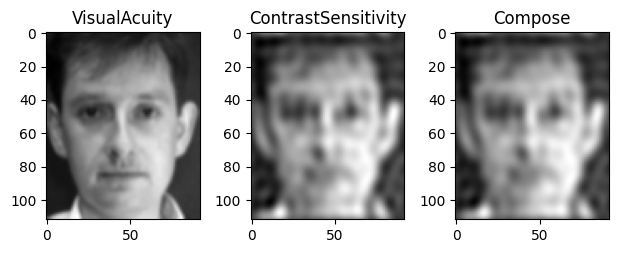

In [116]:
age = 12
sample = img_path[67]


va = VisualAcuity(age=age)
cs = ContrastSensitivity(age=age)
composed = transforms.Compose([VisualAcuity(age=age),
                               ContrastSensitivity(age=age)])

def visualize(output_image):
    # Convert output_image from PyTorch tensor to NumPy array
    if isinstance(output_image, torch.Tensor):
        output_image = output_image.squeeze().numpy()  # Remove unnecessary dimensions

    # Display the image
    plt.imshow(output_image, cmap="gray")


# Apply each of the above transforms on sample.
fig = plt.figure()
for i, tsfrm in enumerate([va, cs, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    visualize(transformed_sample)

plt.show()

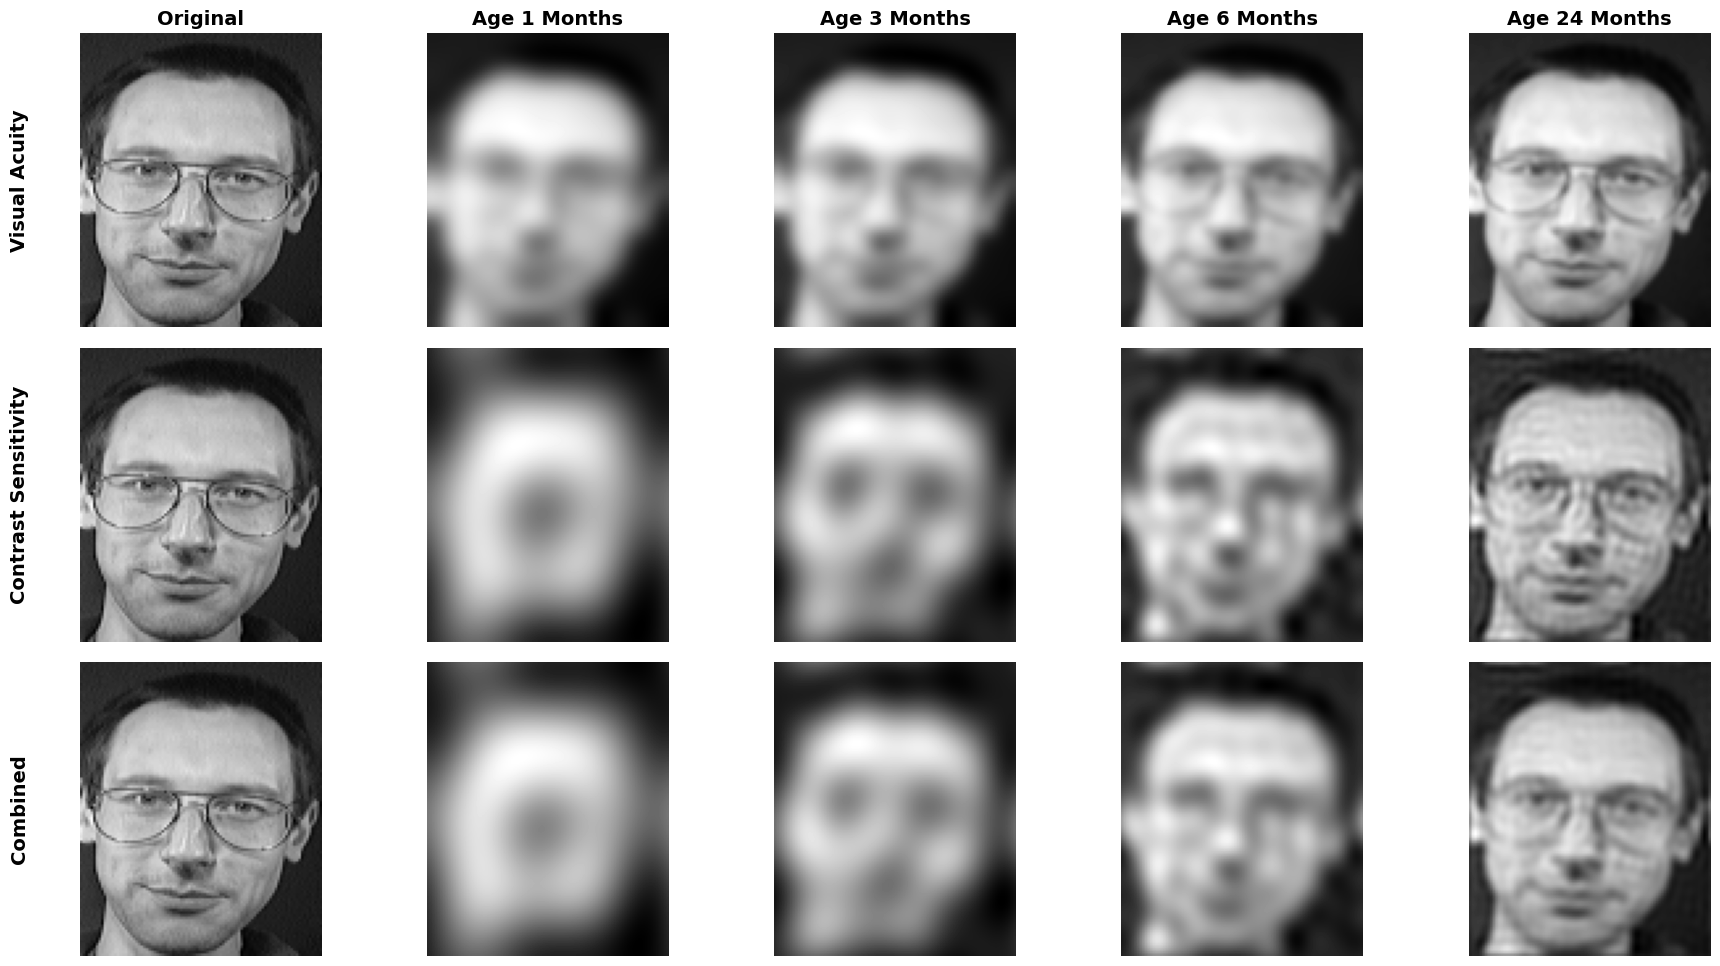

In [135]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image  # For loading images

# Sample image path (replace with actual path to the image)
sample_path = img_path[9]  # Replace with actual image path
sample = Image.open(sample_path).convert("L")  # Load image and convert to grayscale

# Age values for which transformations will be applied
ages = [1, 3, 6, 24]

# Define the transforms for each age
def apply_transforms_for_ages(sample, ages, save_path="transformed_images_with_original2.png"):
    # Set up the figure for plotting
    fig = plt.figure(figsize=(18, 10))

    # Transformation list
    transforms_list = ['Visual Acuity', 'Contrast Sensitivity', 'Combined']

    for j, transform_name in enumerate(transforms_list):
        for i, age in enumerate([0] + ages):  # Include an extra column for the original image
            if i == 0:
                # Use the original image for the first column
                transformed_sample = sample
                col_title = "Original"
            else:
                va = VisualAcuity(age=age)
                cs = ContrastSensitivity(age=age)
                composed = transforms.Compose([VisualAcuity(age=age), ContrastSensitivity(age=age)])

                # Apply the correct transform based on the loop
                if transform_name == 'Visual Acuity':
                    tsfrm = va
                elif transform_name == 'Contrast Sensitivity':
                    tsfrm = cs
                elif transform_name == 'Combined':
                    tsfrm = composed

                # Apply the transform
                transformed_sample = tsfrm(sample)
                col_title = f'Age {age} Months'

            # Plot each transformation in the respective grid position
            ax = plt.subplot(len(transforms_list), len(ages) + 1, j * (len(ages) + 1) + i + 1)
            plt.tight_layout()

            # Add the title for each column (top row titles)
            if j == 0:
                ax.set_title(col_title, fontsize=14, fontweight='bold')  # Larger and bold

            # Add transformation labels on the left side of each row
            if i == 0:
                ax.text(
                    -0.25, 0.5, transform_name, rotation=90, fontsize=14, fontweight='bold',
                    ha='center', va='center', transform=ax.transAxes
                )  # Adjusted closer to images

            # Remove axis ticks for better visualization
            ax.axis('off')
            visualize(transformed_sample)

    # Save the plot to a file
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# Function to visualize the transformed images
def visualize(output_image):
    # Convert output_image to NumPy array if necessary
    if isinstance(output_image, torch.Tensor):
        output_image = output_image.squeeze().numpy()  # Remove unnecessary dimensions
    elif isinstance(output_image, Image.Image):
        output_image = np.array(output_image)  # Convert PIL Image to NumPy array

    # Display the image
    plt.imshow(output_image, cmap="gray")


# Apply transformations for each age and display results
apply_transforms_for_ages(sample, ages)


# **4. Implementation of Dataloader**

In [118]:
# Transformation for visual acuity
transform_va = transforms.Compose([
    transforms.ToTensor(),
    VisualAcuity(age=age),
])

# Transformation for contrast sensitivity
transform_cs = transforms.Compose([
    transforms.ToTensor(),
    ContrastSensitivity(age=age),
])

# Combined transformations
transform_combined = transforms.Compose([
    transforms.ToTensor(),
    VisualAcuity(age=age),
    ContrastSensitivity(age=age),
])

# Without transformations
transform_original = transforms.Compose([
    transforms.ToTensor()
])


# Instantiate the dataset
root_dir = '/kaggle/input/att-database-of-faces'

# Initialize the datasets
dataset_va = VCASDataset(root_dir=root_dir, transform=transform_va) # With visual acuity
dataset_cs = VCASDataset(root_dir=root_dir, transform=transform_cs) # With contrast sensitivity
dataset_combined = VCASDataset(root_dir=root_dir, transform=transform_combined) # With both transformations
dataset_original = VCASDataset(root_dir=root_dir, transform=transform_original) # Without transformations

# Create the DataLoader
dataloader_va = DataLoader(dataset_va, batch_size=4, shuffle=True, num_workers=2)
dataloader_cs = DataLoader(dataset_cs, batch_size=4, shuffle=True, num_workers=2)
dataloader_combined = DataLoader(dataset_combined, batch_size=4, shuffle=True, num_workers=2)
dataloader_original = DataLoader(dataset_original, batch_size=4, shuffle=True, num_workers=2)

In [119]:
dataloader_va.__len__(), dataloader_cs.__len__(), dataloader_combined.__len__(), dataloader_original.__len__()

(100, 100, 100, 100)

In [120]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Define the list of ages
ages = [1, 3, 6, 24]

# Initialize dictionaries to store dataloaders for each age and transformation type
dataloaders_va = {}
dataloaders_cs = {}
dataloaders_combined = {}
dataloaders_original = {}

# Loop through each age to initialize datasets and dataloaders
for age in ages:
    # Define transformations for each age
    transform_va = transforms.Compose([
        transforms.ToTensor(),
        VisualAcuity(age=age),
    ])

    transform_cs = transforms.Compose([
        transforms.ToTensor(),
        ContrastSensitivity(age=age),
    ])

    transform_combined = transforms.Compose([
        transforms.ToTensor(),
        VisualAcuity(age=age),
        ContrastSensitivity(age=age),
    ])

    transform_original = transforms.Compose([
        transforms.ToTensor()
    ])

    # Define root directory
    root_dir = '/kaggle/input/att-database-of-faces'

    # Initialize datasets for each transformation
    dataset_va = VCASDataset(root_dir=root_dir, transform=transform_va)  # With visual acuity
    dataset_cs = VCASDataset(root_dir=root_dir, transform=transform_cs)  # With contrast sensitivity
    dataset_combined = VCASDataset(root_dir=root_dir, transform=transform_combined)  # With both transformations
    dataset_original = VCASDataset(root_dir=root_dir, transform=transform_original)  # Without transformations

    # Create DataLoader for each dataset and age
    dataloaders_va[age] = DataLoader(dataset_va, batch_size=4, shuffle=True, num_workers=2)
    dataloaders_cs[age] = DataLoader(dataset_cs, batch_size=4, shuffle=True, num_workers=2)
    dataloaders_combined[age] = DataLoader(dataset_combined, batch_size=4, shuffle=True, num_workers=2)
    dataloaders_original[age] = DataLoader(dataset_original, batch_size=4, shuffle=True, num_workers=2)

# Now you have a dictionary of dataloaders for each age and transformation type
# You can access the dataloaders using:
# dataloaders_va[age], dataloaders_cs[age], dataloaders_combined[age], dataloaders_original[age]


# **5. Visualize Batches in Dataloader**

Batch shape: torch.Size([4, 112, 92])
Labels: tensor([37, 22, 21, 40])


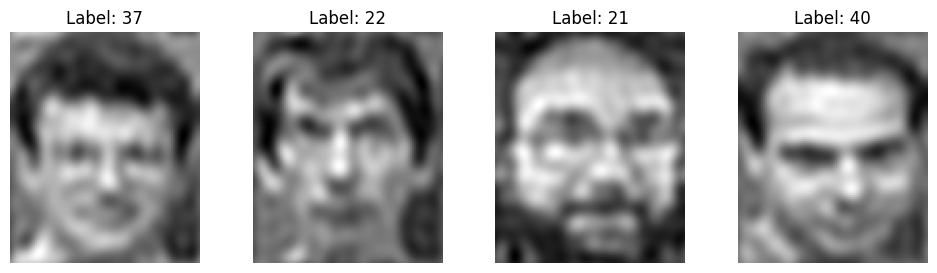

In [121]:
# Function to visualize a batch of images
def visualize_batch(dataloader):
    # Get a batch of data
    batch = next(iter(dataloader))
    
    # Extract images and labels from the batch
    images, labels = batch['image'], batch['label']
    
    # Check the size of the image batch
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels}")
    
    # Convert images from tensor to numpy for visualization
    images = images.numpy()  # Convert from torch tensor to numpy array
    images = images.squeeze()  # Remove channel dimension if grayscale (will make shape [batch_size, height, width])
    
    # Plot the images
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')  
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    
    plt.show()

# Visualize a batch from the dataloader
visualize_batch(dataloader_combined)

Batch shape: torch.Size([4, 1, 1, 112, 92])
Labels: tensor([31, 29, 29,  5])


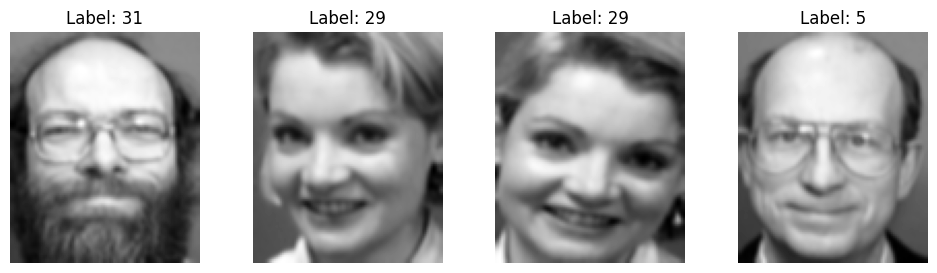

In [122]:
# Visualize a batch from the dataloader
visualize_batch(dataloader_va)

Batch shape: torch.Size([4, 112, 92])
Labels: tensor([31, 30,  2, 28])


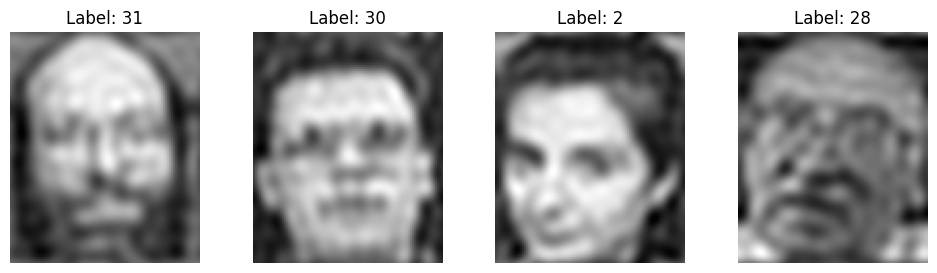

In [123]:
# Visualize a batch from the dataloader
visualize_batch(dataloader_cs)

# **6. Experimental Code for Visualizing Contrast Sensitivity**

Figure saved as csf_images_comparison.png


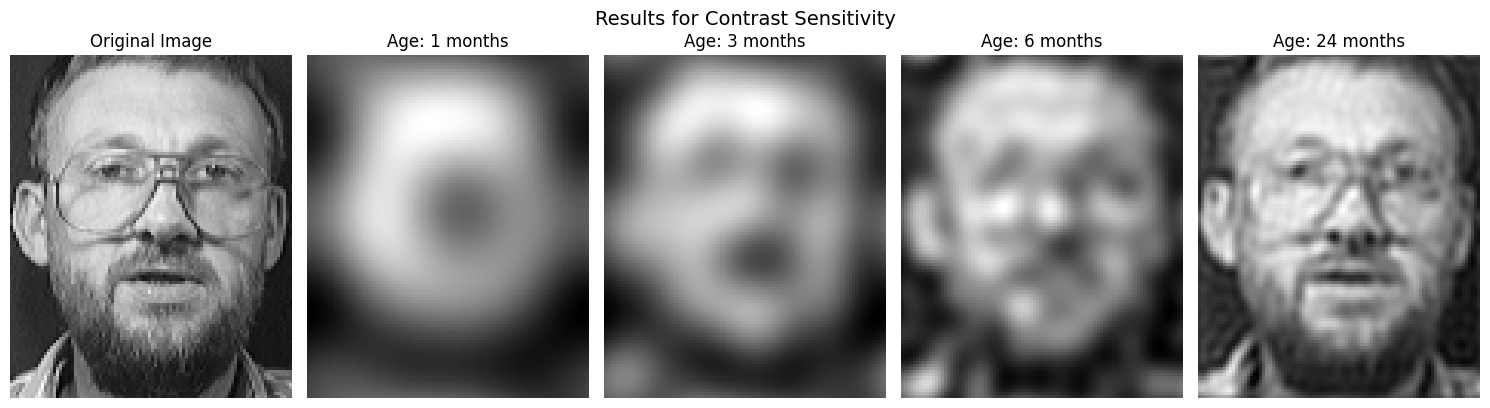

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def apply_csf_filter(image_path, age):
    """
    Parameters:
    image_path: Path to image.
    age: (age in months) to set CSF cutoff frequency.
    Output:
    filtered image after applying the CSF-based low-pass filter.
    """
    
    age_params = Utility(age=age, image_path=image_path)

    snellen_value, sigma = age_params.get_sigma()
    
    # Get cutoff frequency based on age group
    cutoff_frequency = age_params.get_cpd()

    # Load the original image
    image = np.array(age_params.load_image())

    # Fourier Transform to move to frequency domain
    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)  # Shift zero frequency to center

    # Low-pass filter mask
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols), dtype=np.uint8)

    # Mask as a circular low-pass filter based on cutoff frequency
    for i in range(rows):
        for j in range(cols):
            distance = np.sqrt((i - crow) ** 2 + (j - ccol) ** 2)
            if distance <= cutoff_frequency:
                mask[i, j] = 1

    # Apply mask to the frequency domain image
    f_shifted = f_shifted * mask

    # Inverse FFT to return to spatial domain
    f_ishift = np.fft.ifftshift(f_shifted)
    filtered_image = np.fft.ifft2(f_ishift)
    filtered_image = np.abs(filtered_image)  # Get magnitude

    return filtered_image


def display_csf_images(image_path, ages, save_path=None):
    """
    Displays the original and filtered images based on contrast sensitivity function for different ages.
    
    Args:
    - image_path (str): Path to the image to process.
    - ages (list): List of ages to process.
    - save_path (str or None): If a path is provided, the figure will be saved to that path.
    """
    num_ages = len(ages)
    fig, axes = plt.subplots(1, num_ages + 1, figsize=(15, 5))

    # Load the image in grayscale
    original_image = np.array(Image.open(image_path).convert('L'))
    plt.suptitle("Results for Contrast Sensitivity", y=0.90, fontsize=14)
    
    # Show the original image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Apply CSF filter for each age
    for i, age in enumerate(ages, 1):
        filtered_image = apply_csf_filter(image_path, age)
        axes[i].imshow(filtered_image, cmap='gray')
        axes[i].set_title(f"Age: {age} months")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, format='png')
        print(f"Figure saved as {save_path}")
    
    plt.show()

image_path = img_path[76]  # Example image path
ages = [1, 3, 6, 24]  # List of ages in months
save_path = 'csf_images_comparison.png'  # Specify the file path to save the image
display_csf_images(image_path, ages, save_path)


# **Experimental Code for Visualizing Visual Acuity**

Figure saved as visual_acuity_images_comparison.png


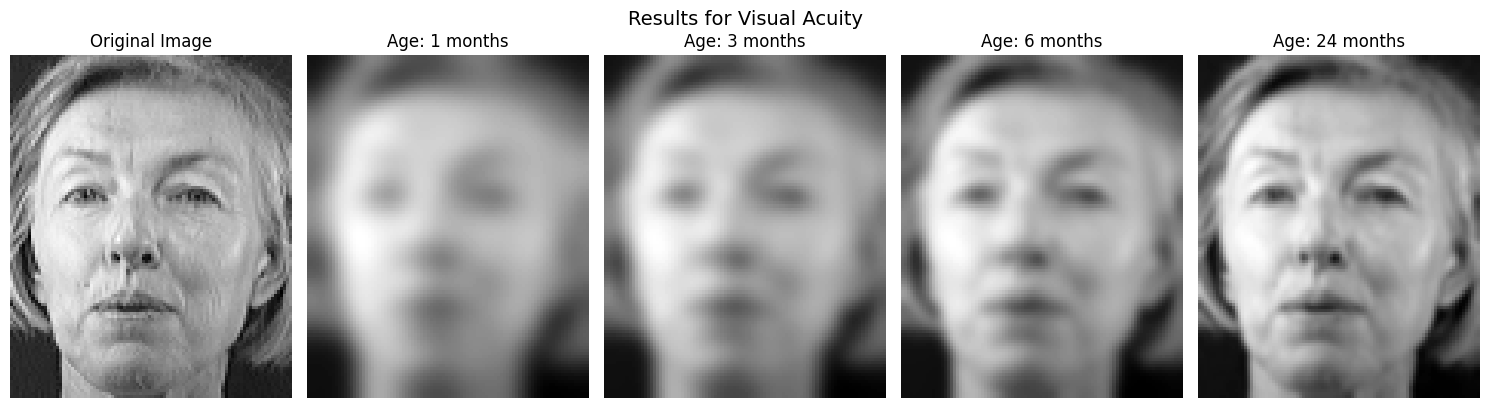

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def apply_gaussian_blur(image_path, age):
    """
    Parameters:
    image_path: Path to image.
    age: (age in months) to get std for gaussian blur.
    Output:
    filtered image after applying the gaussian blur of respective std.
    """
    
    age_params = Utility(age=age, image_path=image_path)
        
    # Load the original image
    original_image = age_params.load_image()
    
    # Convert the image to a PyTorch tensor and add batch and channel dimensions
    original_tensor = transforms.ToTensor()(original_image).unsqueeze(0)

    # Apply Gaussian blur
    snellen_value, sigma = age_params.get_sigma()
    kernel_size = age_params.get_kernel_size(sigma)

    # Apply Gaussian blur to the image tensor
    if sigma > 0:
        blurred_image = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)(original_tensor)
    else:
        # If sigma is 0, the blurred image is the same as the original
        blurred_image = original_tensor

    blurred_image = transforms.ToPILImage()(blurred_image.squeeze(0))
    
    return blurred_image
    

def display_va_images(image_path, ages, save_path=None):
    """
    Displays the original and blurred images based on visual acuity for different ages.
    
    Args:
    - image_path (str): Path to the image to process.
    - ages (list): List of ages to process.
    - save_path (str or None): If a path is provided, the figure will be saved to that path.
    """
    num_ages = len(ages)
    fig, axes = plt.subplots(1, num_ages + 1, figsize=(15, 5))

    # Load the image in grayscale
    original_image = np.array(Image.open(image_path).convert('L'))
    plt.suptitle("Results for Visual Acuity", y=0.90, fontsize=14)

    # Show the original image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Apply Gaussian blur for each age
    for i, age in enumerate(ages, 1):
        blurred_image = apply_gaussian_blur(image_path, age)
        axes[i].imshow(blurred_image, cmap='gray')
        axes[i].set_title(f"Age: {age} months")
        
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, format='png')
        print(f"Figure saved as {save_path}")
    
    plt.show()

image_path = img_path[3]  # Example image path
ages = [1, 3, 6, 24]  # List of ages in months
save_path = 'visual_acuity_images_comparison.png'  # Specify the file path to save the image
display_va_images(image_path, ages, save_path)


Figure saved as visual_acuity_images_comparison.png


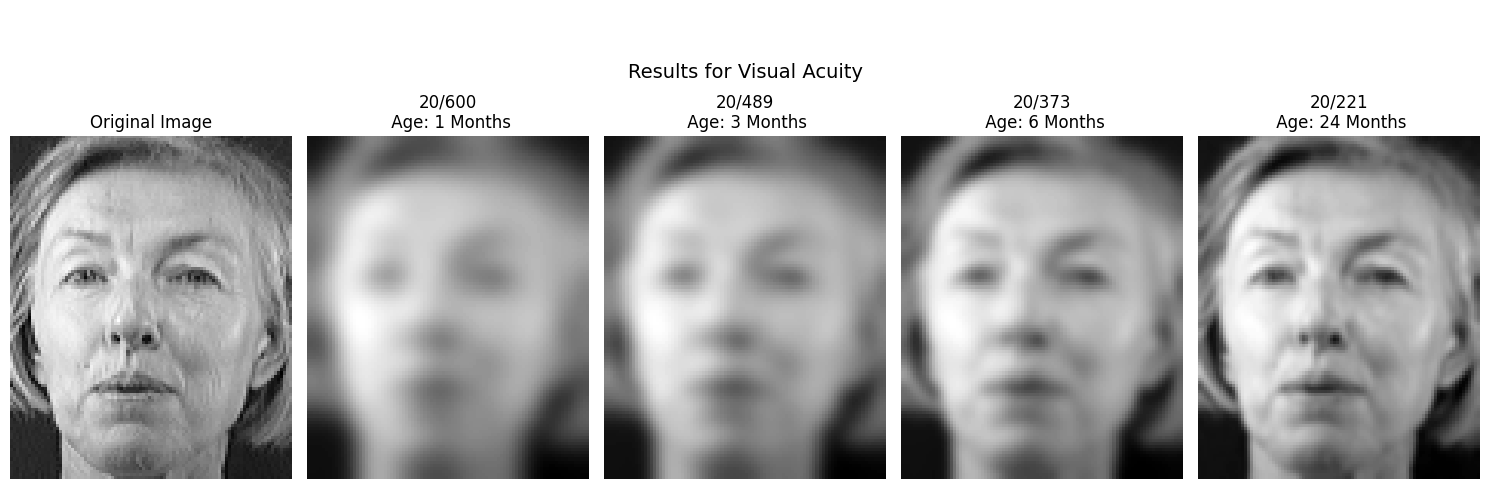

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def apply_gaussian_blur(image_path, age):
    """
    Parameters:
    image_path: Path to image.
    age: (age in months) to get std for gaussian blur.
    Output:
    filtered image after applying the gaussian blur of respective std.
    """
    
    age_params = Utility(age=age, image_path=image_path)
        
    # Load the original image
    original_image = age_params.load_image()
    
    # Convert the image to a PyTorch tensor and add batch and channel dimensions
    original_tensor = transforms.ToTensor()(original_image).unsqueeze(0)

    # Apply Gaussian blur
    snellen_value, sigma = age_params.get_sigma()
    kernel_size = age_params.get_kernel_size(sigma)

    # Apply Gaussian blur to the image tensor
    if sigma > 0:
        blurred_image = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)(original_tensor)
    else:
        # If sigma is 0, the blurred image is the same as the original
        blurred_image = original_tensor

    blurred_image = transforms.ToPILImage()(blurred_image.squeeze(0))
    
    return blurred_image
    

def display_va_images(image_path, ages, save_path=None):
    """
    Displays the original and blurred images based on visual acuity for different ages.
    
    Args:
    - image_path (str): Path to the image to process.
    - ages (list): List of ages to process.
    - save_path (str or None): If a path is provided, the figure will be saved to that path.
    """
    num_ages = len(ages)
    fig, axes = plt.subplots(1, num_ages + 1, figsize=(15, 5))

    # Load the image in grayscale
    original_image = np.array(Image.open(image_path).convert('L'))
    plt.suptitle("Results for Visual Acuity", y=0.90, fontsize=14)

    # Show the original image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Snellen values for each age
    snellen_values = {
        1: "20/600",
        3: "20/489",
        6: "20/373",
        24: "20/221"
    }
    
    # Apply Gaussian blur for each age and set the title with the age and Snellen value
    for i, age in enumerate(ages, 1):
        blurred_image = apply_gaussian_blur(image_path, age)
        axes[i].imshow(blurred_image, cmap='gray')
        axes[i].set_title(f"\n\n\n\n{snellen_values[age]}\n Age: {age} Months")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, format='png')
        print(f"Figure saved as {save_path}")
    
    plt.show()

# Example usage
image_path = img_path[3]  # Example image path
ages = [1, 3, 6, 24]  # List of ages in months
save_path = 'visual_acuity_images_comparison.png'  # Specify the file path to save the image
display_va_images(image_path, ages, save_path)


# **7. Performance Evaluation for One Age**

In [127]:
import time

def evaluate_dataloader_full_performance(dataloader):
    """
    Measures the total time taken to process all batches in a dataloader.

    Args:
    - dataloader (DataLoader): The dataloader to evaluate.

    Returns:
    - float: Total time in seconds to process all batches.
    """
    start_time = time.time()
    for batch in dataloader:
        pass  # Just iterate over the batch, no processing needed
    total_time = time.time() - start_time
    return total_time

# Evaluate performance for each dataloader on the full dataset
time_original = evaluate_dataloader_full_performance(dataloader_original)
time_va = evaluate_dataloader_full_performance(dataloader_va)
time_cs = evaluate_dataloader_full_performance(dataloader_cs)
time_combined = evaluate_dataloader_full_performance(dataloader_combined)

# Print the results
print(f"Performance evaluation for the entire dataset:")
print(f"Original Dataloader: {time_original:.2f} seconds")
print(f"Visual Acuity Dataloader: {time_va:.2f} seconds")
print(f"Contrast Sensitivity Dataloader: {time_cs:.2f} seconds")
print(f"Combined Transformations Dataloader: {time_combined:.2f} seconds")


Performance evaluation for the entire dataset:
Original Dataloader: 0.84 seconds
Visual Acuity Dataloader: 0.89 seconds
Contrast Sensitivity Dataloader: 5.71 seconds
Combined Transformations Dataloader: 6.19 seconds


# **Performance Evalution Graph for One Age**

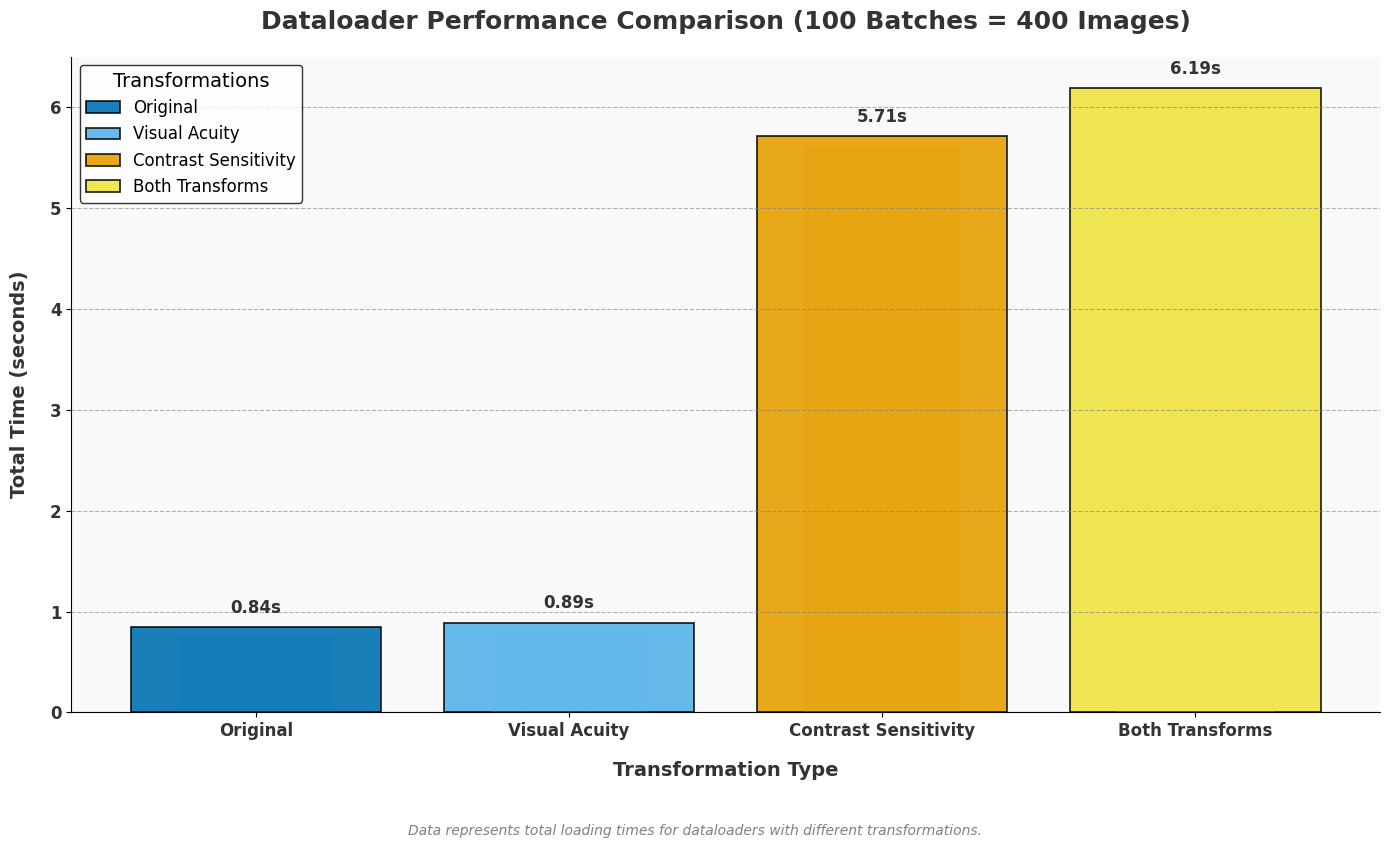

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def professional_visualization(time_original, time_va, time_cs, time_combined):
    # Categories and times
    categories = ['Original', 'Visual Acuity', 'Contrast Sensitivity', 'Both Transforms']
    times = [time_original, time_va, time_cs, time_combined]

    # Color scheme (Colorblind-friendly palette)
    colors = ['#0072B2', '#56B4E9', '#E69F00', '#F0E442']

    # Figure dimensions and background
    plt.figure(figsize=(14, 8), dpi=100)
    plt.gca().set_facecolor('#F9F9F9')  # Light gray background for the plot
    plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')  # Add gridlines for clarity

    # Create bars
    bars = plt.bar(categories, times, color=colors, edgecolor='black', linewidth=1.2)

    # Add shadow-like 3D effect to bars
    for bar in bars:
        bar.set_alpha(0.9)  # Adjust bar transparency
        plt.gca().bar(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.1, width=0.5, alpha=0.2, color=bar.get_facecolor())

    # Add value annotations on top of bars
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X position
            bar.get_height() + 0.1,  # Y position
            f'{bar.get_height():.2f}s',  # Text to display
            ha='center', va='bottom', fontsize=12, fontweight='bold', color='#333'
        )

    # Configure the axes
    plt.xticks(fontsize=12, fontweight='bold', color='#333')  # Format X-axis labels
    plt.yticks(fontsize=12, fontweight='bold', color='#333')  # Format Y-axis labels
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))  # Limit Y-axis to integer values

    # Add title and axis labels
    plt.title('Dataloader Performance Comparison (100 Batches = 400 Images)', fontsize=18, fontweight='bold', color='#333', pad=20)
    plt.xlabel('Transformation Type', fontsize=14, fontweight='bold', color='#333', labelpad=15)
    plt.ylabel('Total Time (seconds)', fontsize=14, fontweight='bold', color='#333', labelpad=15)

    # Add legend
    plt.legend(
        bars,
        categories,
        title='Transformations',
        loc='upper left',
        fontsize=12,
        title_fontsize=14,
        frameon=True,
        edgecolor='black'
    )

    # Add a footer (explanatory text at the bottom of the plot)
    plt.figtext(
        0.5, -0.05,
        'Data represents total loading times for dataloaders with different transformations.',
        ha='center', fontsize=10, color='gray', fontstyle='italic'
    )

    # Remove top and right frame spines for a modern look
    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)

    # Final adjustments
    plt.tight_layout()

    # Save the plot to a file (e.g., 'dataloader_performance.png')
    plt.savefig('dataloader_performance.png', bbox_inches='tight', dpi=300)

    # Show the plot
    plt.show()


professional_visualization(time_original, time_va, time_cs, time_combined)


# **Performance Evaluation for Four Ages**

In [137]:
import time
import matplotlib.pyplot as plt

# Function to measure the performance of the dataloader
def evaluate_dataloader_full_performance(dataloader):
    """
    Measures the total time taken to process all batches in a dataloader.

    Args:
    - dataloader (DataLoader): The dataloader to evaluate.

    Returns:
    - float: Total time in seconds to process all batches.
    """
    start_time = time.time()
    for batch in dataloader:
        pass  # Just iterate over the batch, no processing needed
    total_time = time.time() - start_time
    return total_time

# Create a dictionary to store results for different ages
ages = [1, 3, 6, 24]
results = {}  # Dictionary to store the processing times for each age group

for age in ages:
    # Get the dataloaders for the current age
    dataloader_original = dataloaders_original[age]
    dataloader_va = dataloaders_va[age]
    dataloader_cs = dataloaders_cs[age]
    dataloader_combined = dataloaders_combined[age]

    # Measure performance
    time_original = evaluate_dataloader_full_performance(dataloader_original)
    time_va = evaluate_dataloader_full_performance(dataloader_va)
    time_cs = evaluate_dataloader_full_performance(dataloader_cs)
    time_combined = evaluate_dataloader_full_performance(dataloader_combined)

    # Save the results
    results[age] = {
        'Original': time_original,
        'Visual Acuity': time_va,
        'Contrast Sensitivity': time_cs,
        'Combined': time_combined,
    }

    # Print the results
    print(f"Performance evaluation for age {age}:")
    print(f"Original Dataloader: {time_original:.2f} seconds")
    print(f"Visual Acuity Dataloader: {time_va:.2f} seconds")
    print(f"Contrast Sensitivity Dataloader: {time_cs:.2f} seconds")
    print(f"Combined Transformations Dataloader: {time_combined:.2f} seconds")
    print("-" * 50)


Performance evaluation for age 1:
Original Dataloader: 0.67 seconds
Visual Acuity Dataloader: 2.06 seconds
Contrast Sensitivity Dataloader: 5.66 seconds
Combined Transformations Dataloader: 6.76 seconds
--------------------------------------------------
Performance evaluation for age 3:
Original Dataloader: 0.52 seconds
Visual Acuity Dataloader: 1.56 seconds
Contrast Sensitivity Dataloader: 5.71 seconds
Combined Transformations Dataloader: 7.02 seconds
--------------------------------------------------
Performance evaluation for age 6:
Original Dataloader: 0.51 seconds
Visual Acuity Dataloader: 1.14 seconds
Contrast Sensitivity Dataloader: 5.80 seconds
Combined Transformations Dataloader: 6.05 seconds
--------------------------------------------------
Performance evaluation for age 24:
Original Dataloader: 0.53 seconds
Visual Acuity Dataloader: 0.91 seconds
Contrast Sensitivity Dataloader: 5.67 seconds
Combined Transformations Dataloader: 6.11 seconds
----------------------------------

# **Performance Evaluation Line Graph for Four Ages**

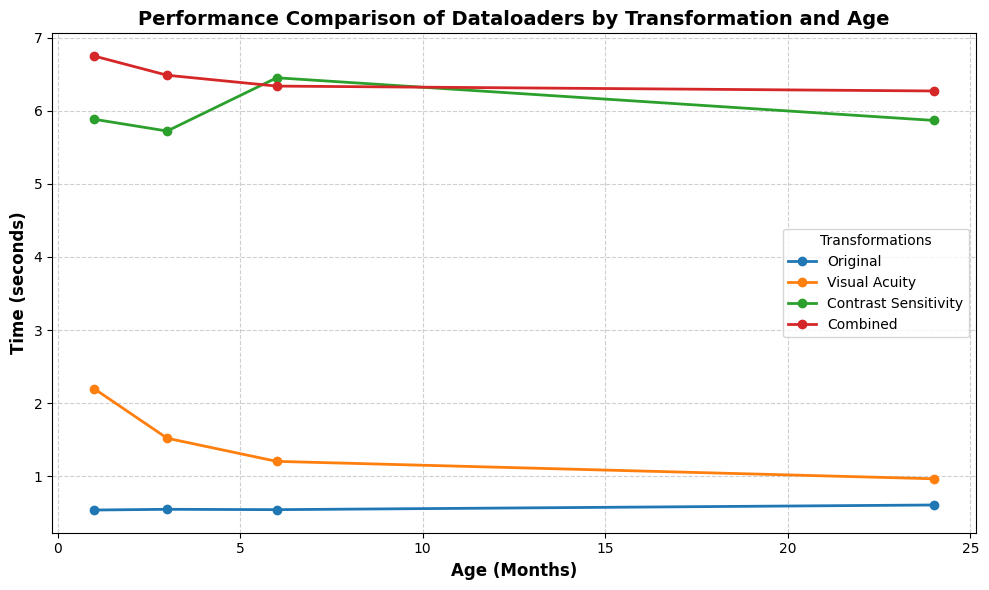

In [136]:
import matplotlib.pyplot as plt

# Function to plot a performance comparison chart
def plot_performance_comparison_line(results):
    """
    Plots a line chart comparing the performance of dataloaders for different transformations.
    
    Args:
    - results (dict): A dictionary containing the performance results for different transformations and ages.
    """
    # Extract transformation types and ages
    transformations = ['Original', 'Visual Acuity', 'Contrast Sensitivity', 'Combined']
    ages = list(results.keys())  # Ages

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot a line for each transformation type
    for transformation in transformations:
        times = [results[age][transformation] for age in ages]  # Get the times for each age
        plt.plot(ages, times, marker='o', label=transformation, linewidth=2)

    # Customize the plot
    plt.xlabel('Age (Months)', fontsize=12, fontweight='bold')
    plt.ylabel('Time (seconds)', fontsize=12, fontweight='bold')
    plt.title('Performance Comparison of Dataloaders by Transformation and Age', fontsize=14, fontweight='bold')
    plt.legend(title='Transformations', fontsize=10)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Save the plot as a PNG file
    plt.savefig('performance_comparison.png', bbox_inches='tight', dpi=300)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Display the results in the plot
plot_performance_comparison_line(results)
